# Intro to Rubin Catalog Operations

In this tutorial, we will:
- explore the basics of column discovery
- work with an individual lightcurve
- apply common filtering operations
- calculate basic aggregation statistics

## Introduction

This tutorial showcases a handful of basic LSDB operations that should be useful when working with Rubin (DP1) data. These operations are likely to be used regardless of science case, and the particular examples in this tutorial should allow you to understand how to use these operations in other ways. For example, while we filter by photometric band in one of the example below, that filter can easily be modified to filter by a quality flag in the data.

## Loading Data

The details of loading Rubin data are discussed in [How to Access Data](TODO:linktorubin), so we'll just provide a starter codeblock below:

In [1]:
from upath import UPath
import lsdb
from lsdb import ConeSearch

base_path = UPath("/rubin/lsdb_data")
object_collection = lsdb.open_catalog(base_path / "object_collection")

# Cone search on ECDFS (Extended Chandra Deep Field South)
object_collection = lsdb.open_catalog(
    base_path / "dia_object_collection",
    search_filter=ConeSearch(ra=52.838, dec=-28.279, radius_arcsec=5000),
)
object_collection

,dec,diaObjectId,nDiaSources,ra,radecMjdTai,tract,diaObjectForcedSource,diaSource
npartitions=42,,,,,,,,
"Order: 10, Pixel: 9198847",double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<band: [string], coord_dec: [double], co...","nested<band: [string], centroid_flag: [bool], ..."
"Order: 6, Pixel: 35933",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143825",...,...,...,...,...,...,...,...
"Order: 6, Pixel: 35957",...,...,...,...,...,...,...,...


As mentioned beneath the catalog dataframe, the view above is a "lazy" view of the data. Often, it's nice to preview the first few rows to better understand the contents of the dataset:

In [2]:
object_collection.head(5)

dec         diaObjectId  nDiaSources         ra  \
_healpix_29                                                                  
2528559836917790087 -28.694949  609787430777651220            1  53.446451   
2528559862939733327 -28.688946  609787430777651219            1  53.439723   
2528559881657338699 -28.688324  609787362058174465            1  53.459674   
2528560064243227454 -28.648182  609788117972418767            1  53.429821   
2528606911361164817 -28.630057  609788049252941917            1  53.505678   

                      radecMjdTai  tract  \
_healpix_29                                
2528559836917790087  60632.084896   4849   
2528559862939733327  60632.084896   4849   
2528559881657338699  60632.084896   4849   
2528560064243227454  60632.073989   4849   
2528606911361164817  60632.084896   4849   

                                                 diaObjectForcedSource  \
_healpix_29                                                              
2528559836917790087  [{band: 'z', coord_dec: -28.694949, coord_ra: ...   
2528559862939733327  [{band: 'z', coord_dec: -28.688946, coord_ra: ...   
2528559881657338699  [{band: 'z', coord_dec: -28.688324, coord_ra: ...   
2528560064243227454  [{band: 'r', coord_dec: -28.648182, coord_ra: ...   
2528606911361164817  [{band: 'z', coord_dec: -28.630057, coord_ra: ...   

                                                             diaSource  
_healpix_29                                                             
2528559836917790087  [{band: 'z', centroid_flag: False, coord_dec: ...  
2528559862939733327  [{band: 'z', centroid_flag: False, coord_dec: ...  
2528559881657338699  [{band: 'z', centroid_flag: False, coord_dec: ...  
2528560064243227454  [{band: 'r', centroid_flag: False, coord_dec: ...  
2528606911361164817  [{band: 'z', centroid_flag: False, coord_dec: ...

### Viewing Available Columns

The [schema browser](https://sdm-schemas.lsst.io/dp1.html) provides the most information regarding available (DP1) columns, there is also a handful of properties useful for quick column discovery within the LSDB API. First, `all_columns` gives a view of **all** available columns in the HATS catalog, even if only a handful of columns were selected on load:

In [3]:
object_collection.all_columns

['ra',
 'dec',
 'nDiaSources',
 'radecMjdTai',
 'g_psfFluxLinearSlope',
 'g_psfFluxLinearIntercept',
 'g_psfFluxMAD',
 'g_psfFluxMaxSlope',
 'g_psfFluxErrMean',
 'g_psfFluxMean',
 'g_psfFluxMeanErr',
 'g_psfFluxNdata',
 'g_scienceFluxMean',
 'g_scienceFluxMeanErr',
 'g_psfFluxMin',
 'g_psfFluxMax',
 'g_psfFluxPercentile05',
 'g_psfFluxPercentile25',
 'g_psfFluxPercentile50',
 'g_psfFluxPercentile75',
 'g_psfFluxPercentile95',
 'g_psfFluxSigma',
 'g_scienceFluxSigma',
 'g_psfFluxSkew',
 'g_psfFluxChi2',
 'g_psfFluxStetsonJ',
 'r_psfFluxLinearSlope',
 'r_psfFluxLinearIntercept',
 'r_psfFluxMAD',
 'r_psfFluxMaxSlope',
 'r_psfFluxErrMean',
 'r_psfFluxMean',
 'r_psfFluxMeanErr',
 'r_psfFluxNdata',
 'r_scienceFluxMean',
 'r_scienceFluxMeanErr',
 'r_psfFluxMin',
 'r_psfFluxMax',
 'r_psfFluxPercentile05',
 'r_psfFluxPercentile25',
 'r_psfFluxPercentile50',
 'r_psfFluxPercentile75',
 'r_psfFluxPercentile95',
 'r_psfFluxSigma',
 'r_scienceFluxSigma',
 'r_psfFluxSkew',
 'r_psfFluxChi2',
 'r_psfFl

Any nested columns (see [Understanding the NestedFrame](https://docs.lsdb.io/en/latest/tutorials/pre_executed/nestedframe.html) for an explanation on what these are) will have their own sets of sub-columns as well, we can first identify any nested columns programmatically using the `nested_columns` property:

In [4]:
object_collection.nested_columns

['diaObjectForcedSource', 'diaSource']

To view the available sub-columns, we use the `nest` accessor for one of the nested columns:

In [5]:
object_collection["diaObjectForcedSource"].columns

['band',
 'coord_dec',
 'coord_ra',
 'diff_PixelFlags_nodataCenter',
 'forcedSourceOnDiaObjectId',
 'invalidPsfFlag',
 'midpointMjdTai',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_nodata',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'psfDiffFlux',
 'psfDiffFlux_flag',
 'psfDiffFluxErr',
 'psfFlux',
 'psfFlux_flag',
 'psfFluxErr',
 'psfMag',
 'psfMagErr',
 'visit']

## Viewing a Single Lightcurve

Selecting a single lightcurve is most effectively done via the `id_search` function, in this case we have a particular "diaObjectId" in mind:

In [6]:
objectid = 609782208097419314
single_id = object_collection.id_search(values={"diaObjectId": objectid}).compute()
single_id

Searching for diaObjectId=609782208097419314


dec         diaObjectId  nDiaSources         ra  \
_healpix_29                                                                  
2528690302717534293 -28.279918  609782208097419314          371  52.838269   

                      radecMjdTai  tract  \
_healpix_29                                
2528690302717534293  60655.249976   4848   

                                                 diaObjectForcedSource  \
_healpix_29                                                              
2528690302717534293  [{band: 'r', coord_dec: -28.279918, coord_ra: ...   

                                                             diaSource  
_healpix_29                                                             
2528690302717534293  [{band: 'r', centroid_flag: False, coord_dec: ...

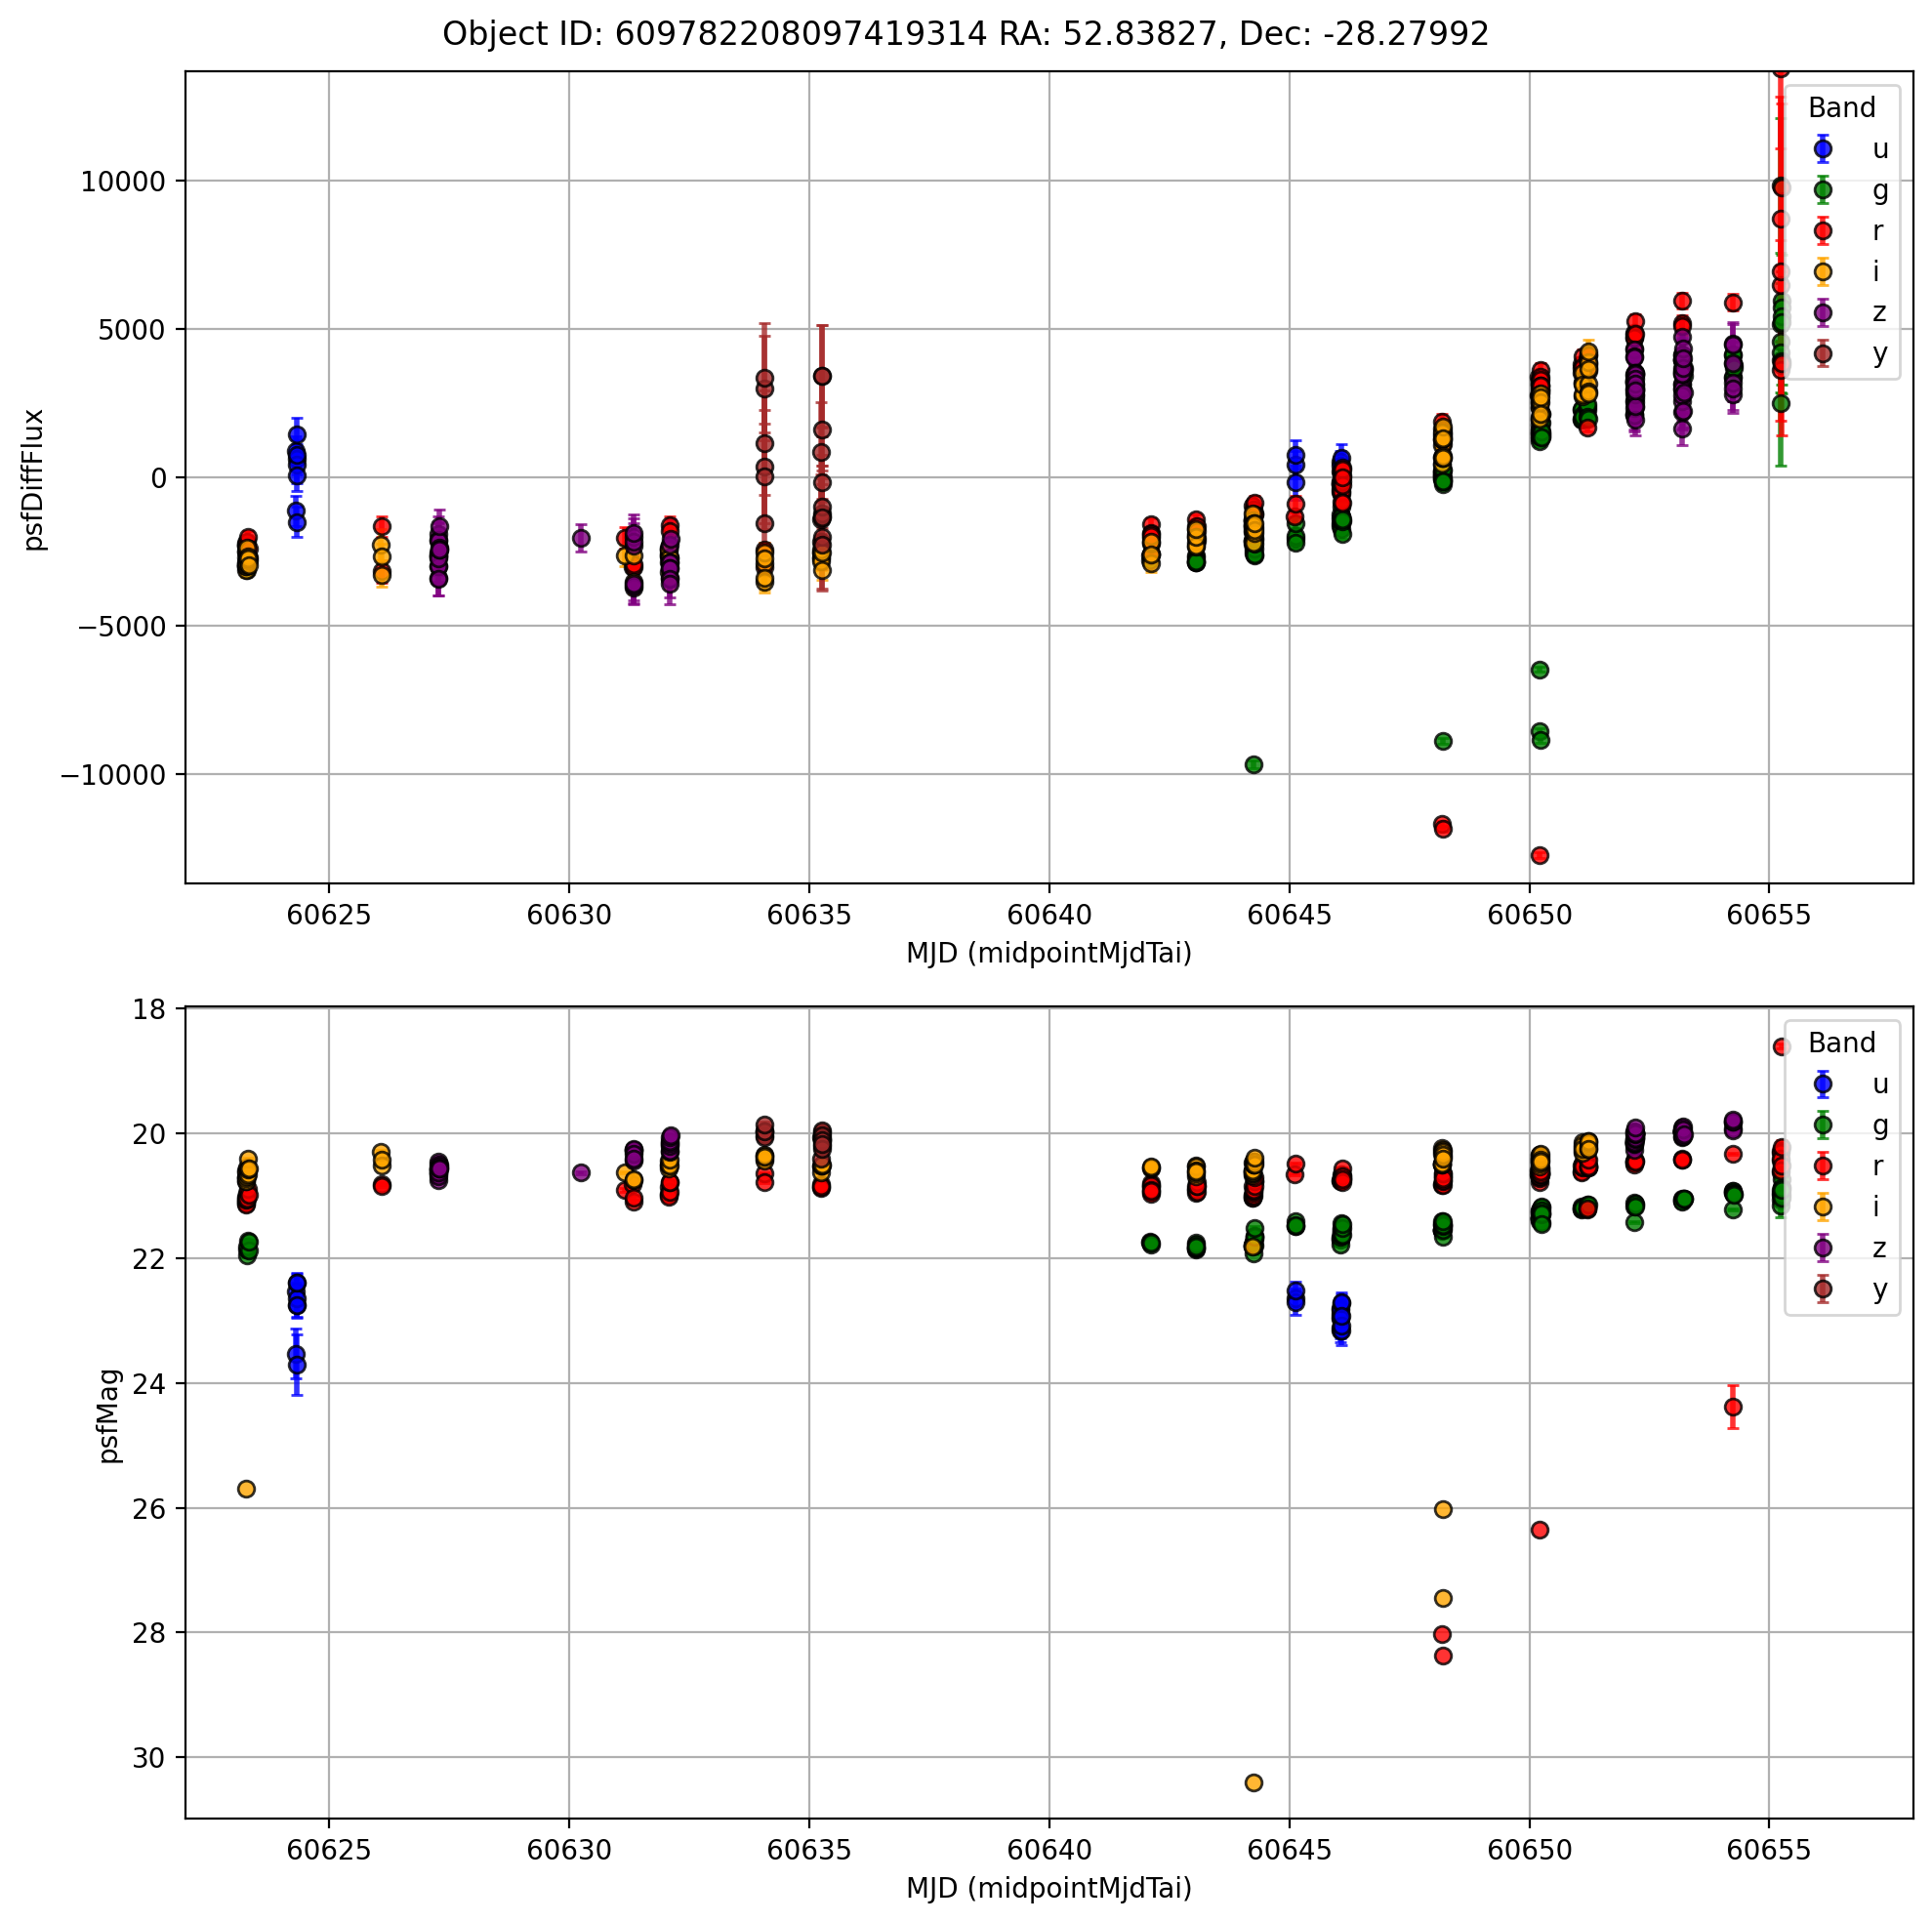

In [7]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np

first_lc = single_id.diaObjectForcedSource.iloc[0]

# Compute symmetric y-limits around 0 using 95% range
flux = first_lc["psfDiffFlux"].dropna()
limit = np.percentile(np.abs(flux), 97.5) + 100
y_min, y_max = -limit, limit

# Start plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200)

# Define band → color mapping
band_colors = {"u": "blue", "g": "green", "r": "red", "i": "orange", "z": "purple", "y": "brown"}

# Plot each band with its color
for band, color in band_colors.items():
    band_data = first_lc[first_lc["band"] == band]
    if band_data.empty:
        continue
    ax[0].errorbar(
        band_data["midpointMjdTai"],
        band_data["psfDiffFlux"],
        yerr=band_data["psfDiffFluxErr"],
        fmt="o",
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=2,
        alpha=0.8,
        markeredgecolor="k",
        label=band,
    )

    ax[1].errorbar(
        band_data["midpointMjdTai"],
        band_data["psfMag"],
        yerr=band_data["psfMagErr"],
        fmt="o",
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=2,
        alpha=0.8,
        markeredgecolor="k",
        label=band,
    )

fig.suptitle(
    f'Object ID: {single_id["diaObjectId"].values[0]} RA: {single_id["ra"].values[0]:.5f}, Dec: {single_id["dec"].values[0]:.5f}'
)

ax[0].invert_yaxis()
ax[0].set_xlabel("MJD (midpointMjdTai)")
ax[0].set_ylabel("psfDiffFlux")
# ax[0].set_title(f'Object ID: {single_id["diaObjectId"].values[0]} RA: {single_id["ra"].values[0]:.5f}, Dec: {single_id["dec"].values[0]:.5f}', fontsize=12)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xlim(60622, 60658)
ax[0].grid(True)
ax[0].legend(title="Band", loc="best")

ax[1].invert_yaxis()
ax[1].set_xlabel("MJD (midpointMjdTai)")
ax[1].set_ylabel("psfMag")
# ax[1].set_title(f'Object ID: {single_id["diaObjectId"].values[0]} RA: {single_id["ra"].values[0]:.5f}, Dec: {single_id["dec"].values[0]:.5f}', fontsize=12)
# ax[1].set_ylim(y_min, y_max)
ax[1].set_xlim(60622, 60658)
ax[1].grid(True)
ax[1].legend(title="Band", loc="best")
plt.tight_layout()

## Common Filtering Operations

### Filtering by Number of Sources

Provided the Source table(s) haven't been modified by any filtering operations, the "nDiaSources" column is directly provided and allows for easy filtering based on lightcurve length. Note that "nDiaSources" is just a static column that maps to the unmodified lengths of DiaSources, once the number of DiaSources is modified then the value in this column will be out of date.

In [8]:
oc_long_lcs = object_collection.query("nDiaSources > 10")
oc_long_lcs.head(5)

dec         diaObjectId  nDiaSources         ra  \
_healpix_29                                                                  
2528607275717728666 -28.583791  609788049252941847           12  53.489935   
2528607345986705737 -28.559039  609788049252941850           12  53.512649   
2528608083060939470 -28.541942  609788049252941840           13  53.556345   
2528608127600158337 -28.532665  609788049252941831           13  53.574546   
2528608365089811280 -28.505685  609788736447709250           11  53.586313   

                      radecMjdTai  tract  \
_healpix_29                                
2528607275717728666  60651.220877   4849   
2528607345986705737  60651.220877   4849   
2528608083060939470  60652.209345   4849   
2528608127600158337  60652.209345   4849   
2528608365089811280  60651.101656   4849   

                                                 diaObjectForcedSource  \
_healpix_29                                                              
2528607275717728666  [{band: 'r', coord_dec: -28.583791, coord_ra: ...   
2528607345986705737  [{band: 'r', coord_dec: -28.559039, coord_ra: ...   
2528608083060939470  [{band: 'r', coord_dec: -28.541942, coord_ra: ...   
2528608127600158337  [{band: 'i', coord_dec: -28.532665, coord_ra: ...   
2528608365089811280  [{band: 'i', coord_dec: -28.505685, coord_ra: ...   

                                                             diaSource  
_healpix_29                                                             
2528607275717728666  [{band: 'g', centroid_flag: True, coord_dec: -...  
2528607345986705737  [{band: 'g', centroid_flag: False, coord_dec: ...  
2528608083060939470  [{band: 'r', centroid_flag: True, coord_dec: -...  
2528608127600158337  [{band: 'i', centroid_flag: False, coord_dec: ...  
2528608365089811280  [{band: 'r', centroid_flag: False, coord_dec: ...

### Filtering by Photometric Band

Another common operation is to filter by band, which can done similarly to above, but using sub-column queries:

In [9]:
oc_long_lcs_g = oc_long_lcs.query("diaObjectForcedSource.band == 'g'")
oc_long_lcs_g.head(5)

dec         diaObjectId  nDiaSources         ra  \
_healpix_29                                                                  
2528607275717728666 -28.583791  609788049252941847           12  53.489935   
2528607345986705737 -28.559039  609788049252941850           12  53.512649   
2528608083060939470 -28.541942  609788049252941840           13  53.556345   
2528608127600158337 -28.532665  609788049252941831           13  53.574546   
2528608365089811280 -28.505685  609788736447709250           11  53.586313   

                      radecMjdTai  tract  \
_healpix_29                                
2528607275717728666  60651.220877   4849   
2528607345986705737  60651.220877   4849   
2528608083060939470  60652.209345   4849   
2528608127600158337  60652.209345   4849   
2528608365089811280  60651.101656   4849   

                                                 diaObjectForcedSource  \
_healpix_29                                                              
2528607275717728666  [{band: 'g', coord_dec: -28.583791, coord_ra: ...   
2528607345986705737  [{band: 'g', coord_dec: -28.559039, coord_ra: ...   
2528608083060939470  [{band: 'g', coord_dec: -28.541942, coord_ra: ...   
2528608127600158337                                               None   
2528608365089811280  [{band: 'g', coord_dec: -28.505685, coord_ra: ...   

                                                             diaSource  
_healpix_29                                                             
2528607275717728666  [{band: 'g', centroid_flag: True, coord_dec: -...  
2528607345986705737  [{band: 'g', centroid_flag: False, coord_dec: ...  
2528608083060939470  [{band: 'r', centroid_flag: True, coord_dec: -...  
2528608127600158337  [{band: 'i', centroid_flag: False, coord_dec: ...  
2528608365089811280  [{band: 'r', centroid_flag: False, coord_dec: ...

> **Note**: Filtering operations on "diaObjectForcedSource" are not propagated to "diaSource". Any filtering operations on "diaSource" should be applied in addition to any operations done on "diaObjectForcedSource".

### Filtering Empty Lightcurves

Sometimes, filters on lightcurves may throw out all observations for certain objects, leading to empty lightcurves as seen for one of the objects above. In this case, we can filter objects with empty lightcurves using `dropna`:

In [10]:
oc_long_lcs_g = oc_long_lcs_g.map_partitions(lambda df: df.dropna(subset=["diaObjectForcedSource"]))
oc_long_lcs_g.head(5)

dec         diaObjectId  nDiaSources         ra  \
_healpix_29                                                                  
2528607275717728666 -28.583791  609788049252941847           12  53.489935   
2528607345986705737 -28.559039  609788049252941850           12  53.512649   
2528608083060939470 -28.541942  609788049252941840           13  53.556345   
2528608365089811280 -28.505685  609788736447709250           11  53.586313   
2528608386523759343 -28.494832  609788736447709234           19  53.584151   

                      radecMjdTai  tract  \
_healpix_29                                
2528607275717728666  60651.220877   4849   
2528607345986705737  60651.220877   4849   
2528608083060939470  60652.209345   4849   
2528608365089811280  60651.101656   4849   
2528608386523759343  60651.101656   4849   

                                                 diaObjectForcedSource  \
_healpix_29                                                              
2528607275717728666  [{band: 'g', coord_dec: -28.583791, coord_ra: ...   
2528607345986705737  [{band: 'g', coord_dec: -28.559039, coord_ra: ...   
2528608083060939470  [{band: 'g', coord_dec: -28.541942, coord_ra: ...   
2528608365089811280  [{band: 'g', coord_dec: -28.505685, coord_ra: ...   
2528608386523759343  [{band: 'g', coord_dec: -28.494832, coord_ra: ...   

                                                             diaSource  
_healpix_29                                                             
2528607275717728666  [{band: 'g', centroid_flag: True, coord_dec: -...  
2528607345986705737  [{band: 'g', centroid_flag: False, coord_dec: ...  
2528608083060939470  [{band: 'r', centroid_flag: True, coord_dec: -...  
2528608365089811280  [{band: 'r', centroid_flag: False, coord_dec: ...  
2528608386523759343  [{band: 'i', centroid_flag: False, coord_dec: ...

## Calculating Basic Statistics

While Rubin DP1 data has many statistics pre-computed in object table column, custom computation of statistics remains broadly useful.

Simple aggregrations can be applied via the `map_rows` function, where below we define a very simple mean magnitude function and pass it along to each row, selecting the "psfMag" sub-column of "diaObjectForcedSource" to compute the mean of for each object.

In [11]:
import numpy as np


def mean_mag(row):
    return {"mean_psfMag": np.mean(row["diaObjectForcedSource.psfMag"])}


# meta defines the expected structure of the result
# append_columns adds the result as a column to the original catalog
oc_mean_mags_g = oc_long_lcs_g.map_rows(
    mean_mag, columns=["diaObjectForcedSource.psfMag"], meta={"mean_psfMag": np.float64}, append_columns=True
)
oc_mean_mags_g.head(10)[["mean_psfMag"]]

,mean_psfMag
_healpix_29,
2528607275717728666,19.411814
2528607345986705737,19.042889
2528608083060939470,17.257166
2528608365089811280,17.539051
2528608386523759343,19.579895
2528611470051636305,19.204950
2528611708541527859,19.087742
2528611724254005370,18.638960
2528652384125757089,17.412634


In this example, we needed to define the dask "meta", see [here](https://docs.lsdb.io/en/latest/tutorials/pre_executed/map_partitions.html#3.3-When-You-Need-meta=) for a more dedicated discussion on meta.

## About
**Author(s):** Doug Branton

**Last updated on:** 20 Jan 2026

If you use lsdb for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).